In this module, we will use the training set generated in *CreateTrainSet* to recognize handwritten digits. 
Before recognition, we need to do certain preprocessing of the image, including converting the image into a binary one and segmentation

Initialize the environment.

In [1]:
%load_ext autoreload
%autoreload 1
# number detected related
import cv2
import os
import numpy as np
import math
from lib import imshow
import random
# camera related
from picamera import PiCamera, Color
from time import sleep
import time
import RPi.GPIO as GPIO


# get the project path
PRJ_PATH = os.getcwd()
# OPENCV_data.npz
TRAIN_DATA_NAME = "OPENCV_data.npz"

<mark style=background-color:yellow>We set up a circuit which can control the electrical level of GPIO.7 (input,board pin 7) and GPIO.1 (output,board pin 12) with a botton.
First, we open the PiCamera and choose the file "plate46.jpg" to store the pihcture we take. 
Then we set the parameters of the camera including brightness, contrast, resolution and ISO speed.
Start preview with camera.start_preview(). Move the camera to locate it correctly for capturing.
Set the level of input(GPIO.7) as 0 and initialize the output as 1 with GPIO.setup(channel,GPIO.IN,pull_up_down=GPIO.PUD_DOWN) and GPIO.setup(channel,GPIO.OUT,initial=True)
When we press the botton to connect input and output, there's a rise of the level of input, which is detected by GPIO.wait_for_edge(channel,GPIO.RISING), permitting the following capturing program to run.
Clean the GPIO, stop preview and close the camera.</mark> 

In [2]:
with  PiCamera() as camera:
    filename = PRJ_PATH +  "/UserData/plate46.jpg"
    
    camera.brightness=60
    camera.contrast=0
    camera.resolution=(1024,768)
    camera.iso=50
    camera.start_preview()
    sleep(2)
    
#     GPIO.IN=7
#     GPIO.OUT=12
    GPIO.setwarnings(False)
    GPIO.setmode(GPIO.BOARD)
    GPIO.setup(7,GPIO.IN,pull_up_down=GPIO.PUD_DOWN)
    GPIO.setup(12,GPIO.OUT,initial=True)
    GPIO.wait_for_edge(7,GPIO.RISING)

    camera.capture(filename,False)
    
    GPIO.cleanup()
    
    camera.stop_preview()
    camera.close()

In [ ]:
%aimport split_img
from split_img import image_split_row, image_split_column

Then we train the KNN with the training data produced eariler in CreateTrainSet.

In [87]:
# load the knn training data
with np.load(PRJ_PATH + '/TrainingData/' + TRAIN_DATA_NAME) as data:
    train = data["train"]
    train_labels = data["train_labels"]
train = train.astype(np.float32)
train_labels = train_labels.astype(np.float32)

# create KNN obj
knn = cv2.ml.KNearest_create()
knn.train(train,cv2.ml.ROW_SAMPLE,train_labels)

True

Now we are going to process a real hand-written image as the image shown below.

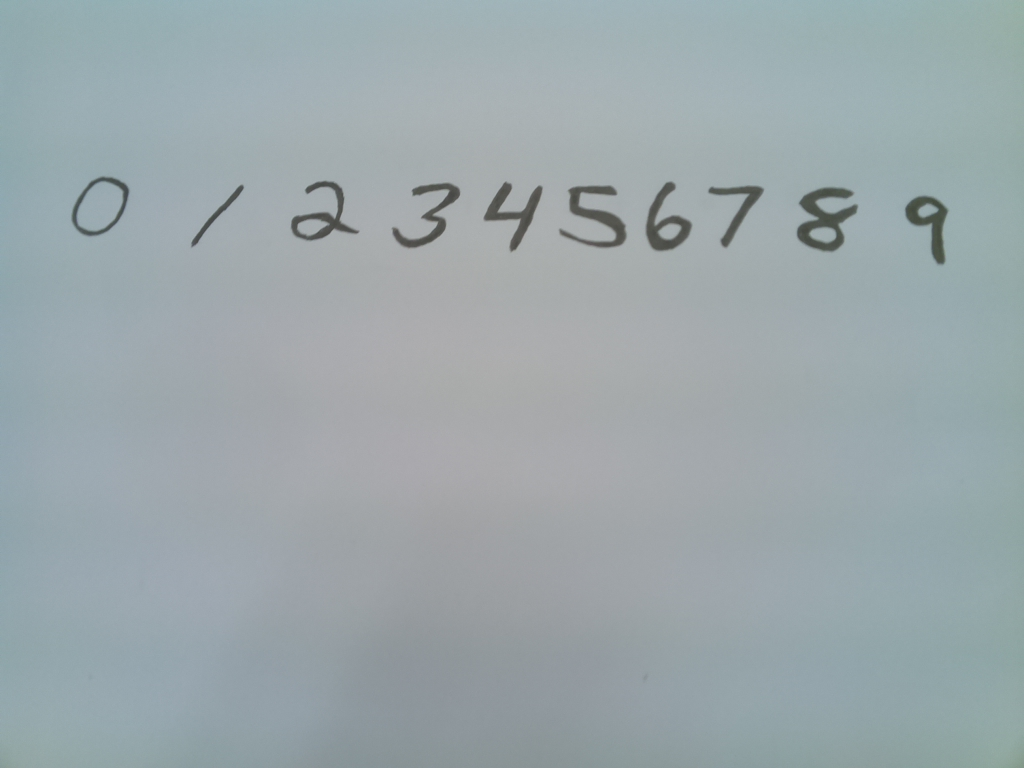

In [88]:
image = PRJ_PATH +  "/UserData/plate46.jpg"
img = cv2.imread(image)
imshow(img)

First, let's convert it into a grayscale image with `dst = cv2.cvtColor(src,code)`.

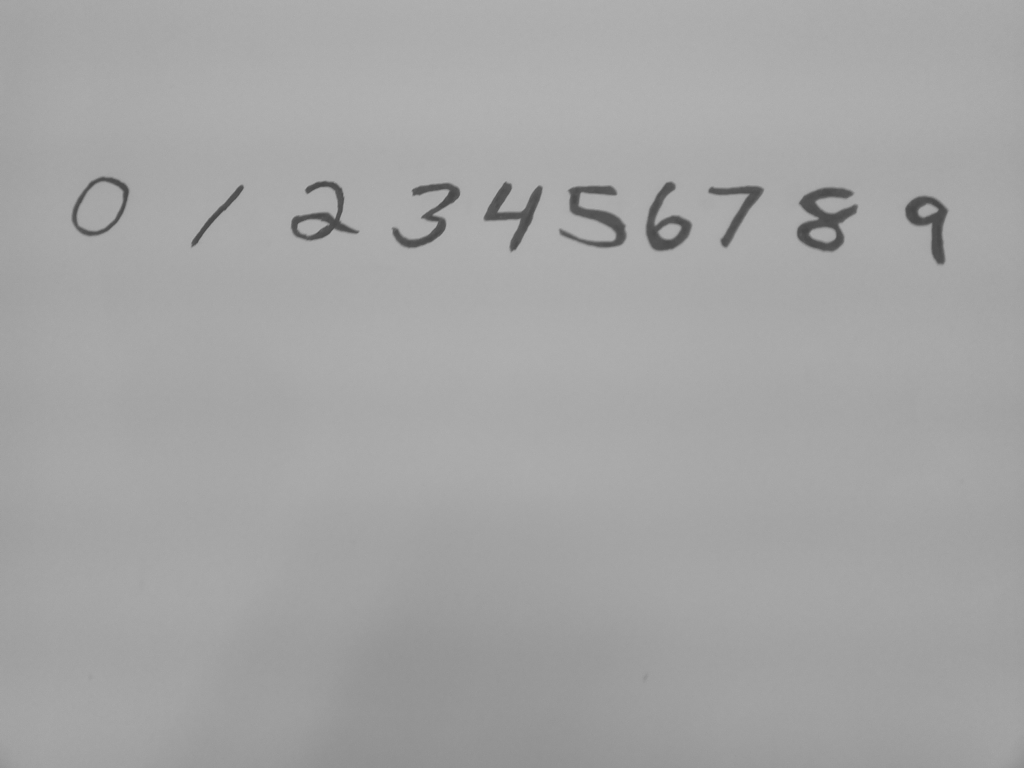

In [89]:
imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
imshow(imgGray)

Then let's convert it into a binary one.

Use `dst=cv2.threshold(src, thresh, maxval, type)` to do so.

Note that the `thresh` parameter need to be tuned manually so that no noisy points presents in the final image.

<mark style=background-color:yellow>这一步用了一个if语句来实现二值化，因为每张图对应二值化的参数是不一样的</mark> 

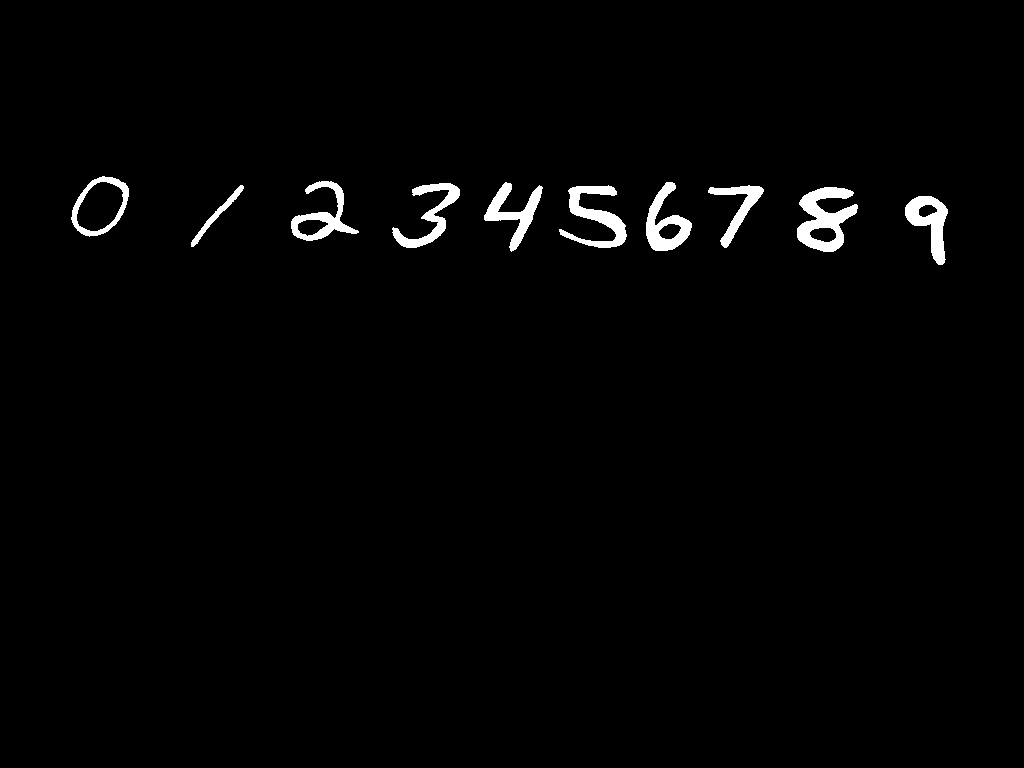

In [92]:
if image == PRJ_PATH +  "/UserData/plate44.jpg":
    _threshold, imgBin = cv2.threshold(imgGray, 50, 255,cv2.THRESH_BINARY_INV)
    imshow(imgBin)
elif image == PRJ_PATH +  "/UserData/plate53.jpg":
    _threshold, imgBin = cv2.threshold(imgGray, 70, 255,cv2.THRESH_BINARY_INV)
    imshow(imgBin)
elif image == PRJ_PATH +  "/UserData/plate46.jpg":
    _threshold, imgBin = cv2.threshold(imgGray, 141, 255,cv2.THRESH_BINARY_INV)
    imshow(imgBin)

Now we need to split the image. But this time the image is not in strict grids, which means we cannot use `np.hsplit()` and `np.vsplit()` anymore.

In the previous steps, we have already change the image into a binary one which only contains 0 and 255. 0 represents black which is the background domain, while 255 represents white which is the digits domain. Thus we can determine the boundary of the digits domain by observing the change of the number of 255 in each line by scanning line by line.
Head to [split_img.py](/edit/split_img.py) (line 87) to complete the code.

Run the cell below to see the splitted image.

10
(0, 0):


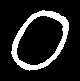

(0, 1):


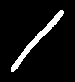

(0, 2):


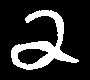

(0, 3):


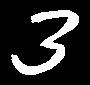

(0, 4):


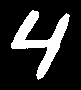

(0, 5):


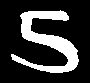

(0, 6):


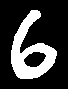

(0, 7):


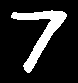

(0, 8):


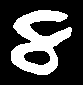

(0, 9):


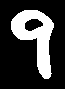

In [93]:
imgCol = image_split_column(imgBin)
print(len(imgCol))
for i in range(0,len(imgCol)):
    imgMonos = image_split_row(imgCol[i])
    for j, imgMono in enumerate(imgMonos):
        print(f"{(j,i)}:")
        imshow(imgMono)

Here comes another problem: these images have different size.
We need to resize them to a uniform shape. 
Also we should reshape the image to make it consistent with the kNN lib. 
Fill in the two variables

In [94]:
resizeSize = ( 20,20 )
reShapeSize = (-1 ,400 )


Run the cell below to get the results.

<mark style=background-color:yellow>在这里使用了一个try语句，因为若识别带有两行数字的图片，需要将任务执行两遍，但识别一行数字的图片则没有这个问题，故用try语句将二者区分开</mark> 

In [98]:
# do the image splite and reshape
# then recognize the number with knn.findNearest(imgReshape,k=?)
try:
    numberList= []
    for i in range(0,len(imgCol)):
        imgMono = image_split_row(imgCol[i])
        imgReshape = cv2.resize(imgMono[0], resizeSize)
        imshow(imgReshape)
        imgReshape = imgReshape.reshape(reShapeSize).astype(np.float32)
        _,result,_,_ = knn.findNearest(imgReshape,k=4)
        numberList.append(int(result))
    print(numberList)
    right=0
    label=range(10)
    for i in range(10):
        if label[i]==numberList[i]:
            right+=1
    acc=right/10
    print('Acc:',acc)
    numberList2 = []
    for i in range(0,len(imgCol)):
        imgMono = image_split_row(imgCol[i])
        imgReshape = cv2.resize(imgMono[1], resizeSize)
        imshow(imgReshape)
        imgReshape = imgReshape.reshape(reShapeSize).astype(np.float32)
        _,result,_,_ = knn.findNearest(imgReshape,k=6)
        numberList2.append(int(result))
    print(numberList2)
    label2=[0,2,1,6,8,5,3,9,7,4]
    right2=0
    for i in range(10):
        if label2[i]==numberList2[i]:
            right2+=1
    acc2=right2/10
    print('Acc:',acc2)    
except IndexError:
    print(' ')


[0, 1, 2, 3, 4, 5, 0, 1, 3, 7]
Acc: 0.6
 
